In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [0]:
np.random.seed(101)
tf.set_random_seed(101)

## Dataset
** Alternative sources of the data just in case: **

* http://yann.lecun.com/exdb/mnist/
* https://github.com/mrgloom/MNIST-dataset-in-different-formats

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
X_train = mnist.train.images
y_train = mnist.train.labels

X_test = mnist.test.images
y_test = mnist.test.labels

display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(55000, 784)

(55000, 10)

(10000, 784)

(10000, 10)

In [5]:
# Dataset is already normalized
display(X_train[2].max())
display(X_train[2].min())

1.0

0.0

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

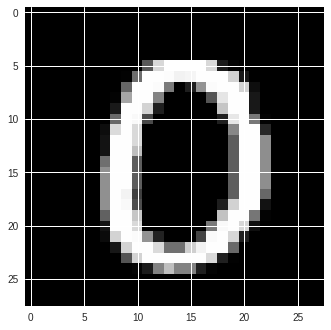

In [6]:
# Sample
plt.imshow(X_train[10].reshape(28,28),cmap='gist_gray')
display(y_train[10])

## Model - Keras

In [7]:
# Equivalent Keras Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Activation, Dropout
import keras.backend as K

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (6, 6), input_shape=(28, 28, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, (6, 6), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Activation('relu'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3212288   
__________

Using TensorFlow backend.


## Model - Tensorflow

In [0]:
def init_weights(shape):
    """Init weight"""
    # Random normal distribution
    init_random_dist = tf.truncated_normal(
        shape, 
        stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    """Init bias"""
    # Constant 0.1
    init_bias_vals = tf.constant(
        0.1,
        shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
def conv2d(x, W):
    # x tensor: [batch, H, W, C]
    # W tensor: [filter H, filter W, Cin, Cout]
    return tf.nn.conv2d(
        x, W,
        strides=[1, 1, 1, 1], 
        padding='SAME')


def conv_layer(x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x, W) + b)


def max_pool_2by2_layer(x):
    # tensor x: [batch, H, W, C]
    return tf.nn.max_pool(
        x, 
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME')


def dense_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [10]:
# Placeholder
x = tf.placeholder(tf.float32,shape=[None,784])
y_true = tf.placeholder(tf.float32,shape=[None,10])

###################################### Stack layers ###############################################

input_img = tf.reshape(x, [-1,28,28,1])

# Feature Extraction layers
convo_1 = conv_layer(
    input_img,
    shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2_layer(convo_1)

convo_2 = conv_layer(
    convo_1_pooling,
    shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2_layer(convo_2)

# Flatten layer
convo_2_flat = tf.reshape(convo_2_pooling,[-1, 7*7*64])

# Fully connected layers
dense_layer_one = tf.nn.relu(
    dense_layer(convo_2_flat, 1024))

hold_prob = tf.placeholder(tf.float32)
dense_one_dropout = tf.nn.dropout(
    dense_layer_one,
    keep_prob=hold_prob)

y_pred = dense_layer(dense_one_dropout, 10)
###################################################################################################

# Loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
# Init Variables
init = tf.global_variables_initializer()

# Steps
steps = 5001

with tf.Session() as sess:
    # Init Variables
    sess.run(init)
    
    for i in range(steps):
        batch_x , batch_y = mnist.train.next_batch(50)
        
        sess.run(
            train,
            feed_dict={
                x:batch_x,
                y_true:batch_y,
                hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 500 STEPS
        if i%500 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(
                acc,
                feed_dict={
                    x:mnist.test.images,
                    y_true:mnist.test.labels,
                    hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1312


Currently on step 500
Accuracy is:
0.9457


Currently on step 1000
Accuracy is:
0.9642


Currently on step 1500
Accuracy is:
0.9726


Currently on step 2000
Accuracy is:
0.9774


Currently on step 2500
Accuracy is:
0.9802


Currently on step 3000
Accuracy is:
0.9822


Currently on step 3500
Accuracy is:
0.9817


Currently on step 4000
Accuracy is:
0.9851


Currently on step 4500
Accuracy is:
0.985


Currently on step 5000
Accuracy is:
0.9873


